In [4]:
# Notebook 9: Regime Evaluation and Strategy Backtest

### 🔹 Objective
#Compare the four regime detection methods (Volatility, Clustering, GMM, HMM) using quantitative metrics (returns, Sharpe ratio, volatility, max drawdown) across each regime. Backtest a simple sector rotation strategy using each regime and evaluate performance.


### 📁 Files Used:
"""
- `processed/regime_labels.csv` → Contains: `Date`, `vol_regime`, `cluster_regime`
- `processed/refined_regime_labels.csv` → Contains: `Date`, `gmm_regime`, `hmm_regime`
- `processed/returns_data.csv` → Contains: `Date`, sector returns for 6 NIFTY indices
"""


'\n- `processed/regime_labels.csv` → Contains: `Date`, `vol_regime`, `cluster_regime`\n- `processed/refined_regime_labels.csv` → Contains: `Date`, `gmm_regime`, `hmm_regime`\n- `processed/returns_data.csv` → Contains: `Date`, sector returns for 6 NIFTY indices\n'

In [7]:
### 📦 Step 1: Load Files and Merge
import pandas as pd

# Load all files
returns = pd.read_csv('../data/processed/returns_data.csv', parse_dates=['Date'])
regimes_vc = pd.read_csv('../data/processed/regime_labels.csv', parse_dates=['Date'])
regimes_gh = pd.read_csv('../data/processed/refined_regime_labels.csv', parse_dates=['Date'])

# Merge regime labels
regimes = pd.merge(regimes_vc, regimes_gh, on='Date')

# Merge with returns
data = pd.merge(returns, regimes, on='Date')
data = data.dropna()
data.head()


,Date,NIFTY_IT,NIFTY_BANK,NIFTY_FMCG,NIFTY_PHARMA,NIFTY_AUTO,NIFTY_METAL,vol_regime,cluster_regime,gmm_regime,hmm_regime
0,2015-04-21,-0.000329,-0.000387,-0.011537,-0.037536,-0.013630,0.001657,2,1,1,0
1,2015-04-22,-0.005761,0.007590,0.005336,0.011924,-0.000555,0.005280,2,1,1,0
2,2015-04-23,-0.003526,0.000104,-0.000628,-0.011187,-0.006239,0.014513,2,1,1,0
3,2015-04-27,-0.031369,-0.026547,-0.017798,-0.025028,-0.005626,-0.000346,2,1,1,0
4,2015-04-28,-0.004059,0.026583,-0.009393,0.006395,0.023945,-0.000346,2,1,1,0


In [8]:
### 📊 Step 2: Evaluation Metrics per Regime

import numpy as np

def compute_metrics(df, regime_col, return_cols):
    metrics = []
    for regime in sorted(df[regime_col].unique()):
        sub = df[df[regime_col] == regime]
        mean_return = sub[return_cols].mean().mean()
        volatility = sub[return_cols].std().mean()
        sharpe = mean_return / volatility if volatility != 0 else 0
        max_dd = (sub[return_cols].cumsum().min().min())
        metrics.append({
            'Regime': regime,
            'Mean Return': mean_return,
            'Volatility': volatility,
            'Sharpe Ratio': sharpe,
            'Max Drawdown': max_dd,
            'Count': len(sub)
        })
    return pd.DataFrame(metrics)

sector_cols = ['NIFTY_IT', 'NIFTY_BANK', 'NIFTY_FMCG', 'NIFTY_PHARMA', 'NIFTY_AUTO', 'NIFTY_METAL']

results = {}
for regime_type in ['vol_regime', 'cluster_regime', 'gmm_regime', 'hmm_regime']:
    results[regime_type] = compute_metrics(data, regime_type, sector_cols)


In [9]:
### 📈 Step 3: Print and Visualize
for key, df in results.items():
    print(f"\n===== {key.upper()} =====")
    print(df.sort_values('Sharpe Ratio', ascending=False))


===== VOL_REGIME =====
   Regime  Mean Return  Volatility  Sharpe Ratio  Max Drawdown  Count
0       0     0.000435    0.009655      0.045098     -0.355998    729
2       2     0.001207    0.029220      0.041295     -0.555771    751
1       1     0.000121    0.011691      0.010349     -0.342412    729

===== CLUSTER_REGIME =====
   Regime  Mean Return  Volatility  Sharpe Ratio  Max Drawdown  Count
2       2     0.018137    0.093424      0.194135     -0.122197     20
1       1     0.000916    0.013537      0.067662     -0.274863   1180
0       0     0.000124    0.027780      0.004449     -0.553340    146
3       3    -0.000174    0.010054     -0.017266     -0.766767    863

===== GMM_REGIME =====
   Regime  Mean Return  Volatility  Sharpe Ratio  Max Drawdown  Count
1       1     0.001973    0.012926      0.152606     -0.149324    849
3       3     0.003295    0.052114      0.063234     -0.599650    155
2       2     0.000595    0.009647      0.061706     -0.268176    847
0       0    -

In [10]:
### 💡 Step 4: Strategy Backtest (Optional Add-on)
"""Create a regime-rotating strategy:
- For each regime, choose the best-performing sector.
- Allocate 100% weight to that sector when in that regime.
- Track cumulative returns.
"""

best_sectors = {}
for regime_type in ['vol_regime', 'cluster_regime', 'gmm_regime', 'hmm_regime']:
    regime_strategy = {}
    for regime in sorted(data[regime_type].unique()):
        sub = data[data[regime_type] == regime]
        mean_returns = sub[sector_cols].mean()
        best_sector = mean_returns.idxmax()
        regime_strategy[regime] = best_sector
    best_sectors[regime_type] = regime_strategy

# Create portfolio returns
portfolio_returns = pd.DataFrame({'Date': data['Date']})
for regime_type in best_sectors:
    strat_returns = []
    for i, row in data.iterrows():
        regime = row[regime_type]
        sector = best_sectors[regime_type][regime]
        strat_returns.append(row[sector])
    portfolio_returns[regime_type + '_returns'] = strat_returns

portfolio_returns.set_index('Date', inplace=True)
portfolio_cumrets = (1 + portfolio_returns).cumprod()

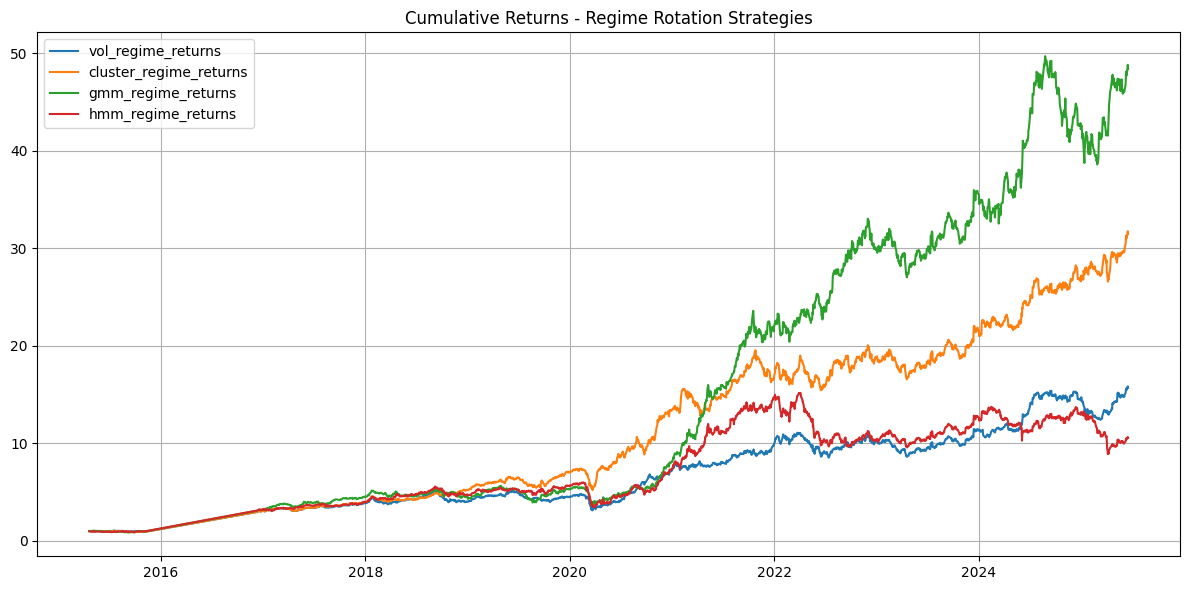

In [11]:
### 📊 Step 5: Final Visualization

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for col in portfolio_cumrets.columns:
    plt.plot(portfolio_cumrets.index, portfolio_cumrets[col], label=col)
plt.title('Cumulative Returns - Regime Rotation Strategies')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


### ✅ Conclusion Plan
This notebook helps answer:
- Which regime method gives better-separated regimes based on return-volatility behavior?
- Which one performs best in a sector rotation strategy?

👉 Based on Sharpe ratios and cumulative returns, we will finalize **the best regime detection method** to be used in Phase 3 (final portfolio optimization & rotation strategy).

Let me know if you'd like to log the metrics, export charts, or prepare summary tables.
